# Classifiez automatiquement des biens de consommation
## Notebook 1 : Prétraitement - Feature extraction - Faisabilité
OpenClassrooms - Parcours Data Scientist - Projet 06  

## Présentation du projet

**Contexte**  


* **Place de marché** souhaite lancer une marketplace e-commerce anglophone  
* Les vendeurs proposent des articles à des acheteurs en postant une photo et une description  
* Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, elle est peu fiable. Le volume des articles est très petit  
* Il devient nécessaire d'**automatiser la tâche d‘attribution de la catégorie**

**Missions**  
* **Étude de faisabilité** (ce Notebook)  
* Classification supervisée à partir des images (Notebook 2)

**Étude de faisabilité**  
* Analyser les descriptions textuelles et les images des produits pour démontrer la faisabilité de regrouper automatiquement des produits de même catégorie
* Étapes :  
   * **Prétraitement** des données texte et image   
   * **Extraction** de features\*
   * **Réduction** en 2 dimensions -> scatterplot avec colorisation de la catégorie réelle
   * **Analyse des graphiques**
   * Réalisation d'une **mesure de similarité** entre les catégories réelles et celle issues d'une segmentation en clusters
* \*Extraction des features **texte** :  
   * 2 approches de type bag-of-words, comptage simple de mots et Tf-idf  
   * 1 approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText)
   * 1 approche de type word/sentence embedding avec BERT
   * 1 approche de type word/sentence embedding avec USE (Universal Sentence Encoder)
* \*Extraction des features **image** :  
   * 1 algorithme de type SIFT / ORB / SURF
   * 1 algorithme de type CNN Transfer Learning 

## Sommaire  
**Préparation de l'environnement**  
* Environnement virtuel
* Import des modules
* Fonctions
* Chargement du dataset  

# 1 Préparation de l'environnement

## 1.1 Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc6


## 1.2 Import des modules

* Installation conditionnelle des librairies

In [2]:
import sys
import subprocess
import pkg_resources

def install_package(package):
    """Installe une librairie en mode silencieux si elle n'est pas encore installée"""
    try:
        pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        print(f"Installation {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"Terminé.")
    else:
        print(f"{package} est déjà installé.")

In [3]:
# Installation des librairies
install_package('pandas')
install_package('numpy')
install_package('matplotlib')
install_package('seaborn')
install_package('scikit-learn')
install_package('nltk')
install_package('pandarallel')
install_package('ipywidgets')
install_package('scipy<1.13')  # Nécessaire pour gensim
install_package('gensim')
install_package('sentence-transformers')
install_package('torch')
install_package('tensorflow')
# install_package('transformers')
install_package('tensorflow_hub')
# install_package('yellowbrick')

pandas est déjà installé.
numpy est déjà installé.
matplotlib est déjà installé.
seaborn est déjà installé.
scikit-learn est déjà installé.
nltk est déjà installé.
pandarallel est déjà installé.
ipywidgets est déjà installé.
scipy<1.13 est déjà installé.
gensim est déjà installé.
sentence-transformers est déjà installé.
torch est déjà installé.
Installation tensorflow... Terminé.
tensorflow_hub est déjà installé.


* Import des modules

In [4]:
# Import des modules
import os
import time
import ipywidgets
import pickle

from pandarallel import pandarallel
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

from gensim.models import Word2Vec

# from transformers import BertTokenizer, TFBertModel
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import tensorflow_hub as hub

from utils import get_dataframe_infos, plot_distribution

# import matplotlib as mpl
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.metrics import silhouette_score
# from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.neighbors import NearestNeighbors
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
# import scipy.cluster.hierarchy as sch

* Import des ressources NLTK

In [5]:
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

* Paramétrages

Un certain nombre de cellules de ce notebook sont longues à calculer  
Pour toutes les opérations coûteuses en temps un fichier contenent leur résultat a été enregistré (csv, pickle ou png)  
En mode **FAST_MODE**, les fichiers sont chargés en priorité s'ils existent (sinon ils sont créés)

In [6]:
# FAST_MODE = False # Force l'exécution du code concerné, et écrase les fichiers s'ils existent
FAST_MODE = True

In [7]:
# Nombre de coeurs disponibles
print(os.cpu_count())

16


In [8]:
# Nombre de coeurs à utiliser
NUM_CORES = 8

In [9]:
pandarallel.initialize(
    progress_bar = True,
    nb_workers = NUM_CORES
)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


# 2 Analyse de faisabilité à partir des données texte

* Chargement du dataset

In [10]:
# Conversion du fichier csv en DataFrame
df_datas = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [11]:
# Affichage de quelques lignes
display(df_datas.head(3))

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [12]:
# Informations sur les variables
display(get_dataframe_infos(df_datas))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,uniq_id,object,1050,0,0,0.0 %
1,crawl_timestamp,object,149,901,0,0.0 %
2,product_url,object,1050,0,0,0.0 %
3,product_name,object,1050,0,0,0.0 %
4,product_category_tree,object,642,408,0,0.0 %
5,pid,object,1050,0,0,0.0 %
6,retail_price,float64,354,695,1,0.1 %
7,discounted_price,float64,424,625,1,0.1 %
8,image,object,1050,0,0,0.0 %
9,is_FK_Advantage_product,bool,2,1048,0,0.0 %


## 2.1 Analyse des variables pertinentes

### 2.1.1 `product_name`

In [13]:
# Affichage de quelques exemples
for index_product in range(20):
    print(f"{df_datas['product_name'][index_product]}")

Elegance Polyester Multicolor Abstract Eyelet Door Curtain
Sathiyas Cotton Bath Towel
Eurospa Cotton Terry Face Towel Set
SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet
Jaipur Print Cotton Floral King sized Double Bedsheet
Maserati Time R8851116001 Analog Watch  - For Boys
Camerii WM64 Elegance Analog Watch  - For Men, Boys
T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys
Alfajr WY16B Youth Digital Watch  - For Men, Boys
TAG Heuer CAU1116.BA0858 Formula 1 Analog Watch  - For Boys, Men
Calibro SW-125 Analog-Digital Watch  - For Men, Boys
Cartier W6701005 Analog Watch  - For Boys, Men
Lois Caron LCS-4032 Analog Watch  - For Boys, Men
Titan 1639SL03 Analog Watch  - For Boys, Men
Srushti Art Jewelry Megnet_Led_Sport_BlackRed1 Digital Watch  - For Men, Women, Boys, Girls
Escort E-1700-906_Blk Analog Watch  - For Men, Boys
Jack klein BlackLed Digital Watch  - For Boys
North Moon IW-005-FK Silicone Ion Digital Watch  - For Boys, Girls, Women
Franck Bella FB74C Analog Watch  

* A première vue, le nom des produits devrait permettre une bonne catégorisation

### 2.1.2 `product_category_tree`

Cette variable contient la catégorie des produits

In [14]:
# Affichage de quelques exemples
for index_product in range(6):
    display(df_datas['product_category_tree'][index_product])

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

'["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'

'["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]'

'["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]'

'["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]'

'["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]'

La catégorie principale se trouve entre '**["**' et la première occurence de '**\>\>**'

* Création d'une variable avec la catégorie principale

In [15]:
# Récupération du texte entre '["' et la première occurence de ' >>'
df_datas['category'] = df_datas['product_category_tree'].apply(lambda x: x.split('["')[1].split(' >>')[0])

* Liste des catégories

In [16]:
display(df_datas['category'].value_counts().reset_index())

,category,count
0,Home Furnishing,150
1,Baby Care,150
2,Watches,150
3,Home Decor & Festive Needs,150
4,Kitchen & Dining,150
5,Beauty and Personal Care,150
6,Computers,150


* Répartition des produits par catégories

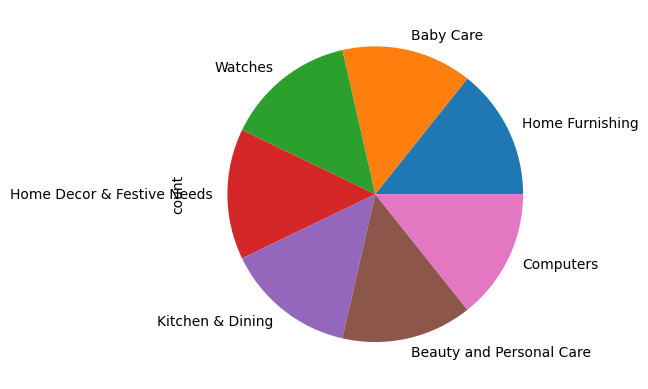

In [17]:
df_datas['category'].value_counts().plot(kind='pie')
plt.show()

Le dataset comprend 1050 produits, répartis de manière équitable en 7 catégories de 150 produits

### 2.1.3 `image`

Cette variable contient le nom des fichiers JPG correspondants aux produits

* Toutes les images sont-elles présentes dans le dossier 'Images' ?

In [18]:
# Liste des fichiers présents
images_path = './Images/'
images_files = os.listdir(images_path)

In [19]:
# Ajout d'une variable indiquant si le fichier image est présent
df_datas['image file found'] = df_datas['image'].apply(lambda x: x in images_files)

In [20]:
# Affichage des éventuels fichiers manquants
if df_datas['image file found'].value_counts().iloc[0] == df_datas.shape[0]:
    print(f"Les {df_datas.shape[0]} fichiers image sont présents.")
else:
    print('Fichiers image manquants :')
    display(df_datas[df_datas['image file found'] == False]['image'])

Les 1050 fichiers image sont présents.


### 2.1.4 `description`

Cette variable contient la description des produits

In [21]:
# Affichage de quelques exemples
for index_product in range(2):
    print(f"{df_datas['product_name'][index_product]} :")
    display(df_datas['description'][index_product])
    print()

Elegance Polyester Multicolor Abstract Eyelet Door Curtain :


'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you


Sathiyas Cotton Bath Towel :


'Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel'

* La variable `description` peut être un bon complément à la varaible `product_name` pour prédire la catégorie

### 2.1.5 `brand`

Cette variable contient la marque des produits

In [22]:
# Affichage de quelques exemples
display(df_datas[['product_name', 'brand']].head(5))

,product_name,brand
0,Elegance Polyester Multicolor Abstract Eyelet ...,Elegance
1,Sathiyas Cotton Bath Towel,Sathiyas
2,Eurospa Cotton Terry Face Towel Set,Eurospa
3,SANTOSH ROYAL FASHION Cotton Printed King size...,SANTOSH ROYAL FASHION
4,Jaipur Print Cotton Floral King sized Double B...,Jaipur Print


In [23]:
# Nombre de valeurs uniques
df_datas['brand'].value_counts().reset_index()

,brand,count
0,PRINT SHAPES,11
1,Lapguard,11
2,Lal Haveli,10
3,Raymond,8
4,Aroma Comfort,8
...,...,...
485,Rute,1
486,NAMS,1
487,JewelKraft Designs,1
488,Budding Bees,1


* Il me parait dangereux de tenter de déduire une catégorie à partir de la marque

### 2.1.5 `product_specifications`

Cette variable contient une liste de caractéristiques des produits

In [24]:
# Affichage de quelques exemples
for index_product in range(2):
    print(f"{df_datas['product_name'][index_product]} :")
    display(df_datas['product_specifications'][index_product])
    print()

Elegance Polyester Multicolor Abstract Eyelet Door Curtain :


'{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}'


Sathiyas Cotton Bath Towel :


'{"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "value"=>"Cotton"}, {"key"=>"Design", "value"=>"Self Design"}, {"key"=>"Brand", "value"=>"Sathiyas"}, {"key"=>"Type", "value"=>"Bath Towel"}, {"key"=>"GSM", "value"=>"500"}, {"key"=>"Model Name", "value"=>"Sathiyas cotton bath towel"}, {"key"=>"Ideal For", "value"=>"Men, Women, Boys, Girls"}, {"key"=>"Model ID", "value"=>"asvtwl322"}, {"key"=>"Color", "value"=>"Red, Yellow, Blue"}, {"key"=>"Size", "value"=>"Mediam"}, {"key"=>"Length", "value"=>"30 inch"}, {"key"=>"Width", "value"=>"60 inch"}, {"key"=>"Number of Contents in Sales Package", "value"=>"3"}, {"key"=>"Sales Package", "value"=>"3 Bath Towel"}]}'

* Cette variable semble moins pertinente, elle décrit des caractéristiques plus éloignées des catégories que `product_name` et `description`

### 2.1.6 Un produit moins bien renseigné

Un produit se fait remarquer par son absence de valeurs pour les variables `retail_price`, `discounted_price` et `product_specifications`

In [25]:
# Filtre abscence de 'retail_price'
mask = df_datas['retail_price'].isna()

In [26]:
# Données textuelles
display(df_datas.loc[mask])

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,image file found
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,True


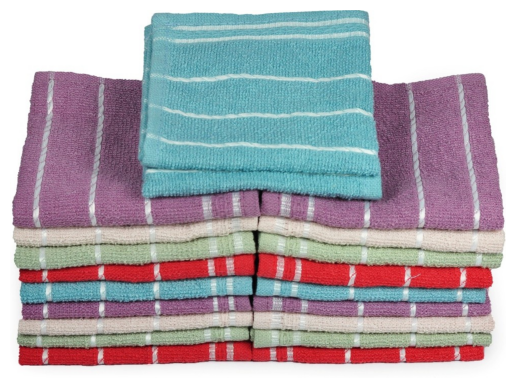

In [27]:
# Image
filename = images_path + df_datas.loc[mask]['image'].iloc[0]
img = plt.imread(filename)
plt.imshow(img)
plt.axis('off')
plt.show()

* Ce produit n'a juste ni prix, ni spécifications
* Les données utiles étant présentes, aucune action spécifique n'est menée

## 2.2 Prétraitement des données texte

### 2.2.1 Concaténation des features `product_name` et `description`

In [28]:
df_datas['product_description'] = df_datas['product_name'].astype(str) + ' ' + df_datas['description'].astype(str)

### 2.2.2 Tokenization

* Transformer un texte en une liste de mots  
* Supprimer tout signe de ponctuation, sauf les tirets et apostrophes qui en anglais peuvent exister dans un mot
* Supprimer les mots n'apportant pas de sens (stop words)
* En option, filtrer pour ne conserver que les noms communs et les verbes 

In [29]:
# Liste des Stop words
stop_words = list(set(stopwords.words('english')))
print(stop_words)

["you'll", 'it', 'there', 'itself', 'nor', 'ourselves', 'on', 'more', 'himself', "doesn't", 'd', 'he', 'my', 'shan', 'a', 'too', 'hadn', 'm', 'about', 'them', 'was', 'me', 'this', 'that', 'y', 'above', 'out', 'be', 'these', 'him', 'both', 'few', 'yours', "it's", 'having', 'mightn', 'where', 'couldn', 'most', 'mustn', 'will', 'against', 'who', 'by', 'over', 'doing', "weren't", 'they', 'she', 'not', "won't", 'their', 'should', 'haven', 'because', 'isn', "you've", 'than', 'at', 'during', 'the', "wouldn't", 'which', 'hers', 'here', 'those', 'just', 'didn', "you're", "that'll", 'you', 'no', 'our', 'own', 'weren', 'in', 'll', 'have', 're', 'his', 'o', 'ma', 'or', 'wasn', 'after', 'themselves', 'been', 'we', "should've", 'do', 'each', 'now', 'whom', "mightn't", "she's", 'its', 's', 'as', 'shouldn', 'her', 'needn', 'same', 'so', 'yourselves', 'don', 'with', 'wouldn', 'yourself', 'ours', 'but', 'of', 'some', 'down', 'further', 'when', 'from', 'did', 'being', 'under', 'won', 'through', 'below', 

In [30]:
def tokenize_text(text, nouns_and_verbs_only=True):
    # Conversion du texte en minuscules
    text = text.lower()
    
    # Création d'un tokenizer avec conservation des mot avec apostrophe et tiret
    pattern = r"\b[a-zA-Z\-\']+\b"
    tokenizer = RegexpTokenizer(pattern)

    # Tokenization du texte
    words = tokenizer.tokenize(text)

    # Suppression des stop-words
    words = [word for word in words if word not in stop_words]

    if nouns_and_verbs_only:
        # Application du POS tagging (POS = Part Of Speech)
        tagged_words = nltk.pos_tag(words)
    
        # Récupération des noms communs et verbes
        words = [word for word, tag in tagged_words if tag in ('NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ')]
    
    return words

In [31]:
# Affichage d'un exemple
text = df_datas['product_description'][7]
words = tokenize_text(text, nouns_and_verbs_only=True)
print(f"Texte d'origine : {text}\n")
print(f"Mots : {words}")

Texte d'origine : T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys
                         Price: Rs. 399
				
			Whether you are on your way to work or travelling abroad with family, lifestyle accessories like watches, wallets and belts help to add a touch of sophistication and class to your otherwise mundane and regular daily wear. When it all comes down to it, suave leather belts and intricately designed and finished timepieces are what separate you from the rest.
Whether you are on your way to work or travelling abroad with family, lifestyle accessories like watches, wallets and belts help to add a touch of sophistication and class to your otherwise mundane and regular daily wear. When it all comes down to it, suave leather belts and intricately designed and finished timepieces are what separate you from the rest.

Mots : ['star', 'analog', 'watch', 'boys', 'analog', 'watch', 'boys', 'price', 'rs', 'way', 'work', 'travelling', 'fa

### 2.2.3 Lemmatization

* Transformer les noms communs au pluriel dans leur forme au singulier  
* Transformer les différentes formes verbales dans leur forme à l'infinitif

In [32]:
def tokenize_lemmatize_text(text, nouns_and_verbs_only=True):
    # Conversion du texte en minuscules
    text = text.lower()
    
    # Création d'un tokenizer avec conservation des mot avec apostrophe et tiret
    pattern = r"\b[a-zA-Z\-\']+\b"
    tokenizer = RegexpTokenizer(pattern)

    # Tokenization du texte
    words = tokenizer.tokenize(text)

    # Suppression des stop-words
    words = [word for word in words if word not in stop_words]

    # Application du POS tagging (POS = Part Of Speech)
    tagged_words = nltk.pos_tag(words)

    # Initialisation du lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatisation des noms communs et verbes
    lemmatized_words = []
    for word, tag in tagged_words:
        if tag.startswith('NN'):  # Noms communs (NN, NNS)
            lemma = lemmatizer.lemmatize(word, pos='n')  # Version au singulier
        elif tag.startswith('VB'):  # Verbes (VB, VBD, VBG, VBN, VBP, VBZ)
            lemma = lemmatizer.lemmatize(word, pos='v')  # Version à l'infinitif
        elif nouns_and_verbs_only:
            continue
        else:
            lemma = word
        lemmatized_words.append(lemma)

    return lemmatized_words

In [33]:
# Affichage d'un exemple
text = df_datas['product_description'][7]
words = tokenize_lemmatize_text(text)
print(f"Texte d'origine : {text}\n")
print(f"Mots : {words}")

Texte d'origine : T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys
                         Price: Rs. 399
				
			Whether you are on your way to work or travelling abroad with family, lifestyle accessories like watches, wallets and belts help to add a touch of sophistication and class to your otherwise mundane and regular daily wear. When it all comes down to it, suave leather belts and intricately designed and finished timepieces are what separate you from the rest.
Whether you are on your way to work or travelling abroad with family, lifestyle accessories like watches, wallets and belts help to add a touch of sophistication and class to your otherwise mundane and regular daily wear. When it all comes down to it, suave leather belts and intricately designed and finished timepieces are what separate you from the rest.

Mots : ['star', '-bk-br', 'analog', 'watch', 'boys', '-bk-br', 'analog', 'watch', 'boys', 'price', 'r', 'way', 'work'

### 2.2.4 Suppression des mots courts

In [34]:
def tokenize_lemmatize_text(text, nouns_and_verbs_only=True, min_length=3):
    # Conversion du texte en minuscules
    text = text.lower()
    
    # Création d'un tokenizer avec conservation des mot avec apostrophe et tiret
    pattern = r"\b[a-zA-Z\-\']+\b"
    tokenizer = RegexpTokenizer(pattern)

    # Tokenization du texte
    words = tokenizer.tokenize(text)

    # Suppression des stop-words
    words = [word for word in words if word not in stop_words]

    # Application du POS tagging (POS = Part Of Speech)
    tagged_words = nltk.pos_tag(words)

    # Initialisation du lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatisation des noms communs et verbes
    lemmatized_words = []
    for word, tag in tagged_words:
        if tag.startswith('NN'):  # Noms communs (NN, NNS)
            lemma = lemmatizer.lemmatize(word, pos='n')  # Version au singulier
        elif tag.startswith('VB'):  # Verbes (VB, VBD, VBG, VBN, VBP, VBZ)
            lemma = lemmatizer.lemmatize(word, pos='v')  # Version à l'infinitif
        elif nouns_and_verbs_only:
            continue
        else:
            lemma = word
        lemmatized_words.append(lemma)

    # Suppression des mots courts
    if min_length > 1:
        lemmatized_words = [word for word in lemmatized_words if len(word) >= min_length]

    return lemmatized_words

In [35]:
# Affichage d'un exemple
text = df_datas['product_description'][7]
words = tokenize_lemmatize_text(text, min_length=3)
print(f"Texte d'origine : {text}\n")
print(f"Mots : {words}")

Texte d'origine : T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys
                         Price: Rs. 399
				
			Whether you are on your way to work or travelling abroad with family, lifestyle accessories like watches, wallets and belts help to add a touch of sophistication and class to your otherwise mundane and regular daily wear. When it all comes down to it, suave leather belts and intricately designed and finished timepieces are what separate you from the rest.
Whether you are on your way to work or travelling abroad with family, lifestyle accessories like watches, wallets and belts help to add a touch of sophistication and class to your otherwise mundane and regular daily wear. When it all comes down to it, suave leather belts and intricately designed and finished timepieces are what separate you from the rest.

Mots : ['star', '-bk-br', 'analog', 'watch', 'boys', '-bk-br', 'analog', 'watch', 'boys', 'price', 'way', 'work', 'tr

### 2.2.5 Création du corpus 'product_descriptions'

In [36]:
# Concaténation des modalités de 'product_name'
product_descriptions = ' '.join(df_datas['product_description'].values)
display(product_descriptions[:1000])

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant

In [37]:
# Tokenization et lematization
product_descriptions_words = tokenize_lemmatize_text(product_descriptions, nouns_and_verbs_only=True, min_length=3)
product_descriptions_words[: 10]

['elegance',
 'polyester',
 'multicolor',
 'eyelet',
 'door',
 'curtain',
 'feature',
 'elegance',
 'polyester',
 'multicolor']

In [38]:
# Nombre de tokens du corpus
len(product_descriptions_words)

42733

In [39]:
# Répartition des fréquences
tmp = pd.Series(product_descriptions_words).value_counts().reset_index()
display(tmp)

,index,count
0,product,862
1,buy,582
2,delivery,567
3,replacement,566
4,cash,564
...,...,...
3292,combine,1
3293,honour,1
3294,celebration,1
3295,festivity,1


In [40]:
# Nombre de mots avec une occurence <= 10
occ_tmp = tmp.groupby('count').agg(nb_mots = ('count', 'count')).reset_index().sort_values('count')
occ_tmp.rename(columns={'count': 'occurence'}, inplace=True)
display(occ_tmp.head(10))

,occurence,nb_mots
0,1,871
1,2,723
2,3,367
3,4,238
4,5,149
5,6,137
6,7,79
7,8,69
8,9,51
9,10,40


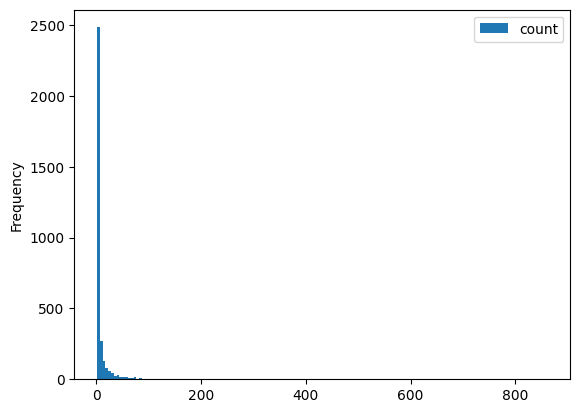

In [41]:
tmp.plot(kind='hist', bins=occ_tmp.shape[0])
plt.show()

* Liste des tokens avec une occurence de 4 ou moins

In [42]:
mask = tmp['count'] <= 4
unique_words = tmp.loc[mask]
unique_words[:20]

,index,count
1098,wonderful,4
1099,ishita,4
1100,force,4
1101,hit,4
1102,rib,4
1103,floralina,4
1104,lilliput,4
1105,club,4
1106,aero,4
1107,step,4


In [43]:
# Création d'une liste
list_unique_words = list(unique_words['index'].values)

# Enregistrement
with open('list_unique_words.pkl', 'wb') as f:
    pickle.dump(list_unique_words, f)

### 2.2.6 Fonction de prétraitement des données texte

* Fonction finale permettant de prétraiter les données, avec les options nécessaires pour les différentes approches

In [44]:
def tokenize_lemmatize_text(text, stop_words=True, nouns_and_verbs_only=True, min_length=3, tokens_to_exclude=[], rejoin=True):
    # Conversion du texte en minuscules
    text = text.lower()
    
    # Création d'un tokenizer avec conservation des mot avec apostrophe et tiret
    pattern = r"\b[a-zA-Z\-\']+\b"
    tokenizer = RegexpTokenizer(pattern)

    # Tokenization du texte
    words = tokenizer.tokenize(text)

    # Suppression des stop-words
    if stop_words:
        words = [word for word in words if word not in stop_words]

    # Application du POS tagging (POS = Part Of Speech)
    tagged_words = nltk.pos_tag(words)

    # Initialisation du lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatisation des noms communs et verbes
    lemmatized_words = []
    for word, tag in tagged_words:
        if tag.startswith('NN'):  # Noms communs (NN, NNS)
            lemma = lemmatizer.lemmatize(word, pos='n')  # Version au singulier
        elif tag.startswith('VB'):  # Verbes (VB, VBD, VBG, VBN, VBP, VBZ)
            lemma = lemmatizer.lemmatize(word, pos='v')  # Version à l'infinitif
        elif nouns_and_verbs_only:
            continue
        else:
            lemma = word
        lemmatized_words.append(lemma)

    # Suppression des mots courts
    if min_length > 1:
        lemmatized_words = [word for word in lemmatized_words if len(word) >= min_length]

    # Suppression des tokens à exclure
    if tokens_to_exclude:
        lemmatized_words = [word for word in lemmatized_words if word not in tokens_to_exclude]
    
    # Option rejoin
    if rejoin:
        lemmatized_words = ' '.join(lemmatized_words)

    return lemmatized_words

### 2.2.7 Traitement feature cible

* Création de la feature `Catégorie` : assignation d'un entier à chaque valeur de `category`

In [45]:
# LabelEncoding
category_label_encoder = LabelEncoder()
df_datas['Catégorie'] = category_label_encoder.fit_transform(df_datas['category'])
display(df_datas.head(2))

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,image file found,product_description,Catégorie
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,True,Elegance Polyester Multicolor Abstract Eyelet ...,4
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,True,Sathiyas Cotton Bath Towel Specifications of S...,0


## 2.3 Tests des modèles

* DataFrame pour stocker les métriques des différentes approches

In [46]:
df_metrics = pd.DataFrame()

* Fonctions communes

In [47]:
def two_dimensions_reduction(datas, target, reduction_method):
    # Exclusion de la variable cible
    X = datas.drop(target, axis=1)

    # Réduction de dimension
    if reduction_method == 'PCA':
        pca = PCA(n_components=2, random_state=0)
        components = pca.fit_transform(StandardScaler().fit_transform(X))
    elif reduction_method == 'TruncatedSVD':
        svd = TruncatedSVD(n_components=2, random_state=0)
        components = svd.fit_transform(X)
    elif reduction_method == 't-SNE':
        tsne = TSNE(n_components=2, random_state=0)
        components = tsne.fit_transform(X)
    else:
        print("Méthode de réduction de dimension inconnue")
        components = None

    return components

In [48]:
def plot_categories_and_kmeans_clusters_after_reduction(datas, target, reduction_method='t-SNE'):
    # Réduction de dimension
    components = two_dimensions_reduction(datas, target, reduction_method)
        
    # Clustering avec KMeans
    kmeans = KMeans(n_clusters=7, random_state=42)
    kmeans_labels = kmeans.fit_predict(components)
    
    # Préparation des données pour la visualisation
    pc_1 = f'{reduction_method} 1'
    pc_2 = f'{reduction_method} 2'
    df_vis = pd.DataFrame(components, columns=[pc_1, pc_2])
    df_vis[target] = datas[target]
    df_vis['Cluster KMeans'] = kmeans_labels
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Colorisation selon 'target'
    sns.scatterplot(data=df_vis, x=pc_1, y=pc_2, hue=target, palette='bright', alpha=0.6, ax=ax[0])
    ax[0].set_title(f"{target} - {reduction_method}")

    # Colorisation selon Clusters KMeans
    sns.scatterplot(data=df_vis, x=pc_1, y=pc_2, hue='Cluster KMeans', palette='bright', alpha=0.6, ax=ax[1])
    ax[1].set_title(f"Clusters KMeans - {reduction_method}")
    
    plt.show()

    return kmeans_labels

In [49]:
def ari_score(true_labels, predicted_labels):
    # Calcul de l'Adjusted Rand Index
    ari_score = adjusted_rand_score(true_labels, predicted_labels)
    
    return ari_score

In [50]:
def compare_real_categories_vs_kmeans_clusters(model_name, datas, target, reduction_method, preprocessing_duration, feature_extraction_duration):
    global df_metrics
    kmeans_labels = plot_categories_and_kmeans_clusters_after_reduction(datas, target, reduction_method)
    score = ari_score(datas[target], kmeans_labels)
    new_row = pd.DataFrame({
        'Modèle': [model_name],
        'Méthode de réduction de dimensions': [reduction_method],
        'Score ARI': [score],
        'Durée totale': [f"{np.round(preprocessing_duration + feature_extraction_duration, 2)} secs"],
        'Durée de prétraitement': [f"{np.round(preprocessing_duration, 2)} secs"],
        'Durée d\'extraction des features': [f"{np.round(feature_extraction_duration, 2)} secs"]
    })
    df_metrics = pd.concat([df_metrics, new_row], ignore_index=True)    
    print(f"Adjusted Rand Index: {score}")

### 2.3.1 Approche CountVectorizer

* **CountVectorizer** compte le nombre de fois où apparait un mot dans un document et crée une matrice de dénombrement des tokens
* L'algorithme travaille à partir d'un "bag of words", c'est-à-dire un ensemble de mots significatifs

#### 2.3.1.1 Bag of words

* Application de la fonction de prétraitement à la variable `product_description` du dataset

In [51]:
def bag_of_words(document):
    from utils import tokenize_lemmatize_text
    import pickle

    with open('list_unique_words.pkl', 'rb') as f:
        list_unique_words = pickle.load(f)
        
    bag_of_words = tokenize_lemmatize_text(
        document,
        exclude_stop_words = True,
        nouns_and_verbs_only = True,
        min_length = 3,
        tokens_to_exclude = list_unique_words,
        rejoin = True
    )

    return bag_of_words

In [52]:
start_bow = time.perf_counter()

# Création de la feature 'bag_of_words' dans le dataframe
df_datas['bag_of_words'] = df_datas['product_description'].parallel_apply(bag_of_words)

end_bow = time.perf_counter()
bow_duration = end_bow - start_bow

In [53]:
# Affichage d'un exemple
print(f"Product description : {df_datas['product_description'][0]}\n")
print(f"Bag of words : {df_datas['bag_of_words'][0]}\n\n")

Product description : Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. B

#### 2.3.1.2 Feature Extraction

* La plupart des hyperparamètres de CountVectorizer sont déjà été gérés via le prétraitement :
    * `min_df` : ignore les mots ayant une fréquence strictement inférieure à 'min_df'
    * `max_df` : ignore les mots ayant une fréquence strictement supérieure à 'min_df'
    * `stop_words` : mots à supprimer
    * `lowercase` : convertit en minuscules avant tokenization
* **`ngram_range`** permet de spécifier une plage de n-grams à extraire

In [54]:
# Initialisation du modèle
cv_model = CountVectorizer(ngram_range=(1, 2))

start_cv = time.perf_counter()
# Entrainement
cv_model.fit(df_datas['bag_of_words'])

# Récupération des features
cv_data = cv_model.transform(df_datas['bag_of_words'])

end_cv = time.perf_counter()
cv_duration = end_cv - start_cv

* Création d'un DataFrame avec les features CountVectorizer et une feature `Catégorie` contenant la catégorie réelle des produits

In [55]:
df_count_vectorizer = pd.DataFrame(
    cv_data.toarray(),
    columns=cv_model.get_feature_names_out()
)
df_count_vectorizer['Catégorie'] = df_datas['Catégorie']

In [56]:
display(df_count_vectorizer.sample(5))

,aapno,aapno rajasthan,aari,aari embroider,aari embroidery,abstract,abstract blanket,abstract checker,abstract color,abstract cushion,...,yes wheel,yes width,yes woman,yuva,yuva analog,yuva gold,zone,zone print,zone protector,Catégorie
209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
752,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### 2.3.1.3 Réduction de dimension et visualisation

* Réduction en 2 dimensions via PCA et représentation des produits

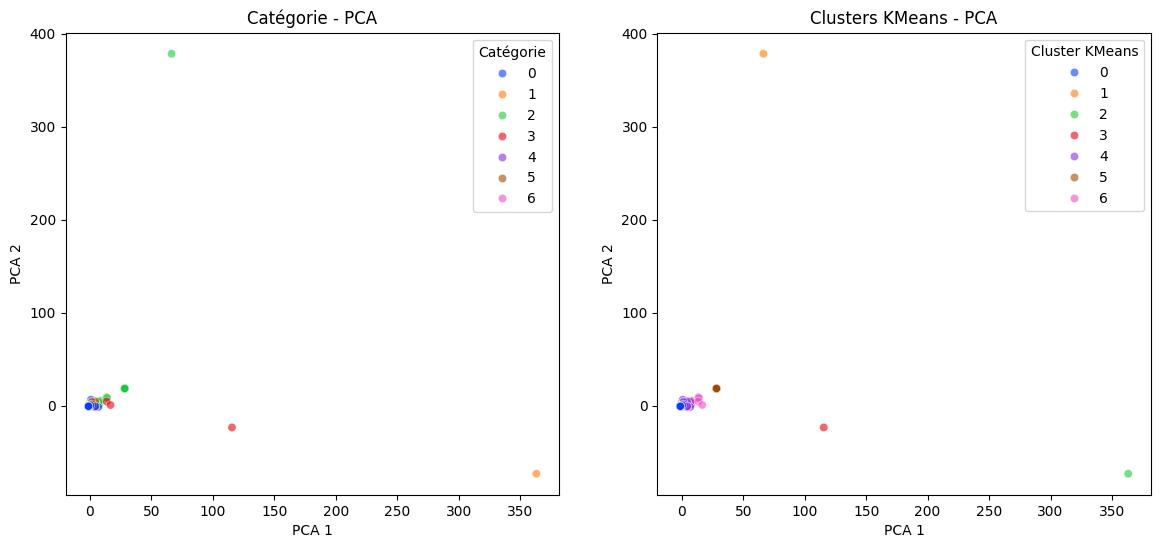

Adjusted Rand Index: 0.0006342958132408249


In [57]:
compare_real_categories_vs_kmeans_clusters('CountVectorizer', df_count_vectorizer, 'Catégorie', 'PCA', bow_duration, cv_duration)

* Réduction en 2 dimensions via TruncatedSVD et représentation des produits

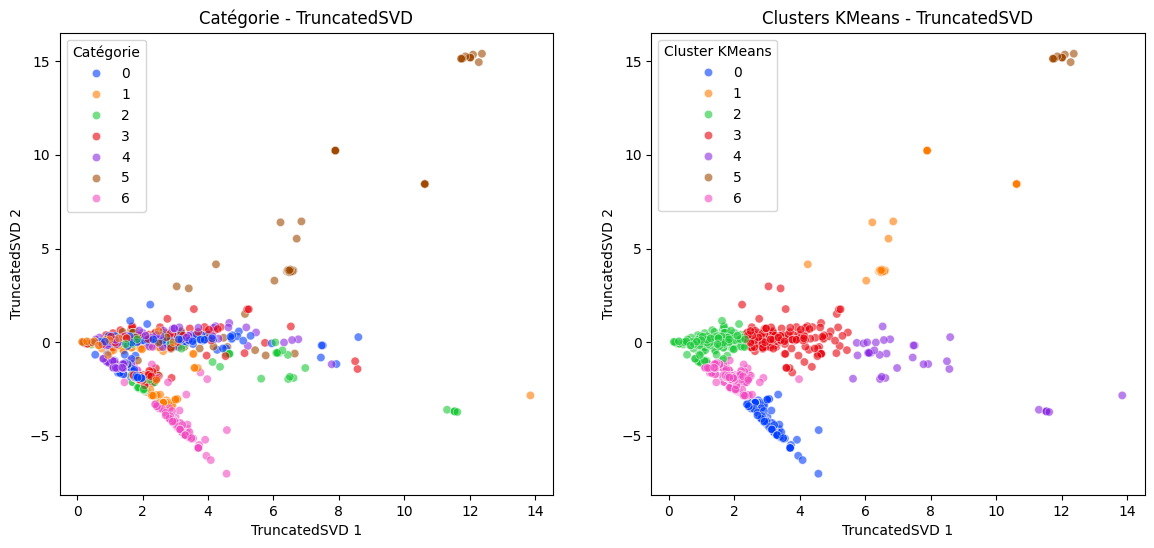

Adjusted Rand Index: 0.16536980630660977


In [58]:
compare_real_categories_vs_kmeans_clusters('CountVectorizer', df_count_vectorizer, 'Catégorie', 'TruncatedSVD', bow_duration, cv_duration)

* Réduction en 2 dimensions via t-SNE et représentation des produits

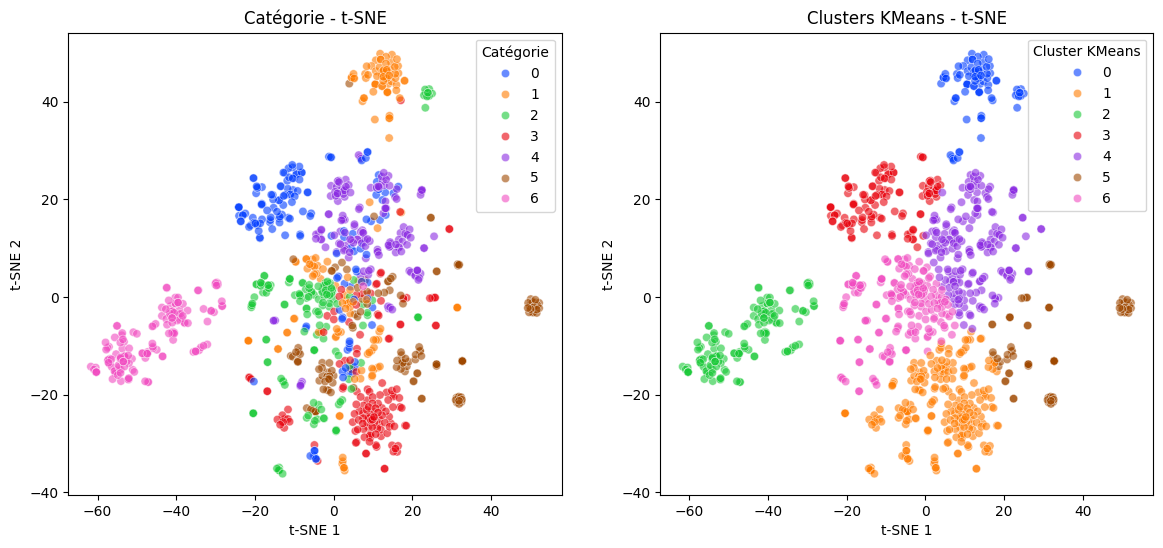

Adjusted Rand Index: 0.4048167326234365


In [59]:
compare_real_categories_vs_kmeans_clusters('CountVectorizer', df_count_vectorizer, 'Catégorie', 't-SNE', bow_duration, cv_duration)

In [60]:
# Affichage des métriques
display(df_metrics.sort_values('Score ARI', ascending=False))

,Modèle,Méthode de réduction de dimensions,Score ARI,Durée totale,Durée de prétraitement,Durée d'extraction des features
2,CountVectorizer,t-SNE,0.404817,6.54 secs,6.43 secs,0.1 secs
1,CountVectorizer,TruncatedSVD,0.165370,6.54 secs,6.43 secs,0.1 secs
0,CountVectorizer,PCA,0.000634,6.54 secs,6.43 secs,0.1 secs


* La réduction de dimension via T-SNE donne les meilleurs résultats que ce soit au niveau visuel ou aniveau du score ARI
* Cette approche sera privilégiée pour les prochains test

In [61]:
# Suppression des résultats TruncatedSVD et PCA
df_metrics = df_metrics.loc[df_metrics['Méthode de réduction de dimensions'] == 't-SNE']

### 2.3.2 Approche Tf-idf

* L'agorithme **Tf-idf (Term Frequency-Inverse Document Frequency)** compte le nombre de fois où apparait un mot dans un document (TF) tout comme `CountVectorizer`, tout en réduisant l'impact des mots qui apparaissent très fréquement dans un corpus (IDF) et qui sont donc moins informatifs que ceux qui apparaissent moint souvent. Le modèle crée une matrice de dénombrement pondérée des tokens
* Tout comme CountVectorizer, Tf-idf fonctionne à partir de bags of words

#### 2.3.2.1 Bag of words

La feature `bag_of_words` créée pour CountVectorizer sera réutilisée

#### 2.3.2.2 Feature extraction

* La plupart des hyperparamètres de `Tf-idf` sont identiques à ceux de `CountVectorizer` et ont déjà été gérés lors de la création des bags of words (`min_df`, `max_df`, `vocabulary`, `stop_words`, `lowercase`)
* Les meilleurs résultats ont été obtenu avec la valeur par défaut de **`ngram_range`**, à savoir l'extraction des unigrams uniquement

In [62]:
# Initialisation du modèle
tfidf_model = TfidfVectorizer()

start_tfidf = time.perf_counter()

# Entraînement
tfidf_model.fit(df_datas['bag_of_words'])

# Récupération des features
tfidf_data = tfidf_model.transform(df_datas['bag_of_words'])

end_tfidf = time.perf_counter()
tfidf_duration = end_tfidf - start_tfidf

* Création d'un DataFrame avec les features TfidfVectorizer et une feature `Catégorie` contenant la catégorie réelle des produits

In [63]:
df_tfidf = pd.DataFrame(
    tfidf_data.toarray(),
    columns=tfidf_model.get_feature_names_out()
)
df_tfidf['Catégorie'] = df_datas['Catégorie']

In [64]:
display(df_tfidf.sample(5))

,aapno,aari,abstract,accessory,accord,adaa,adapter,adaptor,add,addition,...,world,wow,wrap,yardley,year,yellow,yes,yuva,zone,Catégorie
411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1
281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,4
186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.198203,0.0,0.000000,0.0,0.0,5
260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,3
614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.051393,0.0,0.0,3


#### 2.3.3.3 Réduction de dimension et visualisation

* Réduction en 2 dimensions via t-SNE et représentation des produits

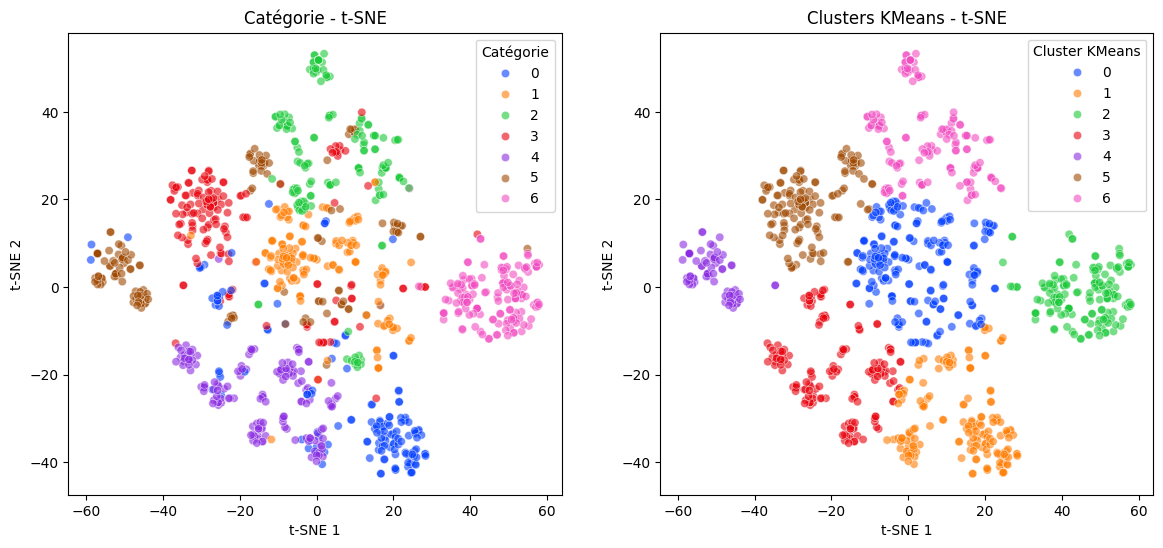

Adjusted Rand Index: 0.5393157583139675


In [65]:
compare_real_categories_vs_kmeans_clusters('Tf-idf', df_tfidf, 'Catégorie', 't-SNE', bow_duration, tfidf_duration)

In [66]:
display(df_metrics.sort_values('Score ARI', ascending=False))

,Modèle,Méthode de réduction de dimensions,Score ARI,Durée totale,Durée de prétraitement,Durée d'extraction des features
1,Tf-idf,t-SNE,0.539316,6.48 secs,6.43 secs,0.04 secs
0,CountVectorizer,t-SNE,0.404817,6.54 secs,6.43 secs,0.1 secs


### 2.3.3 Approche Word2Vect

* **Word2Vec** est un modèle de word embedding qui vectorise chaque mot de manière à ce que les mots ayant des contextes similaires aient des représentations vectorielles similaires
* L'algorithme fonctionne avec des listes de mots et non des bags of words

#### 2.3.3.1 Word embedding

* Il s'agit simplement de fournir à l'algorithme les bags of words créés précedemment sous forme de listes de tokens

In [67]:
def create_lists_of_words(document):
    list_of_words = document.split()
    return list_of_words

In [68]:
# Affichage d'un exemple
print(f"Product description : {df_datas['product_description'][index_product]}\n")
print(f"Liste des mots : {create_lists_of_words(df_datas['bag_of_words'][index_product])}\n\n")

Product description : Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel

Liste des mots : ['cotton', 'bath', 'towel', 'specification', 'cotton', 'bath', 'towel', 'bath', 'towel', 'red', 'bath', 'towel', 'feature', 'machine', 'cotton', 'design', 'design', 'brand', 'type', 'bath', 'towel', 'gsm', 'model', 'name', 'cotton', 'bath', 'towel', 'men', 'woman', 'boy', 'girl', 'model', 'color', 'red', 'blue', 'size', 'dimension', 'length', 'width', 'inch', 'box', 'number', 'content', 'sale', 'package', 'sale', 'package', 'bath', 'towel']




* Création d'une liste pour l'intégralité du corpus. Chaque item de cette liste sera une liste des mots du document de chaque produit

In [69]:
start_we = time.perf_counter()

# Création d'une liste de listes
word_embedding_data = [create_lists_of_words(document) for document in df_datas['bag_of_words']]

end_we = time.perf_counter()
we_duration = bow_duration + (end_we - start_we)

In [70]:
# Affichage de la liste pour les deux premiers produits
print(word_embedding_data[:2])

[['elegance', 'polyester', 'multicolor', 'eyelet', 'door', 'curtain', 'feature', 'elegance', 'polyester', 'multicolor', 'eyelet', 'door', 'curtain', 'curtain', 'elegance', 'polyester', 'multicolor', 'eyelet', 'door', 'curtain', 'height', 'price', 'curtain', 'enhances', 'look', 'interior', 'curtain', 'make', 'quality', 'polyester', 'fabric', 'feature', 'eyelet', 'style', 'metal', 'ring', 'make', 'room', 'curtain', 'give', 'home', 'bright', 'appeal', 'design', 'attention', 'heart', 'eyelet', 'curtain', 'morning', 'bright', 'sun', 'ray', 'want', 'morning', 'world', 'draw', 'create', 'moment', 'beauty', 'give', 'print', 'bring', 'home', 'curtain', 'light', 'room', 'get', 'specification', 'elegance', 'polyester', 'multicolor', 'eyelet', 'door', 'curtain', 'height', 'brand', 'elegance', 'design', 'door', 'type', 'eyelet', 'model', 'name', 'polyester', 'door', 'curtain', 'set', 'model', 'color', 'multicolor', 'dimension', 'length', 'box', 'number', 'content', 'sale', 'package', 'sale', 'packa

#### 2.3.3.2 Feature extraction

Hyperparamètres utilisés :  
* `sentences` : liste de listes de mots  
* `vector_size` : dimensionalité d'un vecteur
* `window` : nombre de mots à prendre avant et après le mot cible pour le contextualiser
* `min_count` : seuil minimal de fréquence des mots, en-dessous duquel un mot ne sera pas pris en compte
* `epochs` : nombre d'itérations que l'algorithme effectue pendant l'entrainement
* `workers` : nombre de threads à utiliser, le maximum étant le nombre de coeurs du processeur  

* Création des features Word2Vec

In [71]:
# Initialisation du modèle
word2vect_model = Word2Vec(
    sentences=word_embedding_data,
    vector_size=100,
    window=6,
    min_count=1,
    epochs=30,
    workers=NUM_CORES
)

In [72]:
# Calcul du vecteur d'un document comme la moyenne des vecteurs des mots du documents
# Les mots inconnus du modèle pré-entraîné sont ignorés
def document_vector(model, doc):
    # Suppression des mots inconnus
    words = [word for word in doc if word in model.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(model.vector_size)
        
    return np.mean(model.wv[words], axis=0)

In [73]:
start_w2v = time.perf_counter()

# Récupération des vecteurs
word2vec_array = np.array([document_vector(word2vect_model, document) for document in word_embedding_data])

end_w2v = time.perf_counter()
w2v_duration = end_w2v - start_w2v

* Création d'un DataFrame avec les vecteurs Word2Vec et une feature `Catégorie` contenant la catégorie réelle des produits

In [74]:
# Création DataFrame avec les vecteurs
df_word2vec = pd.DataFrame(
    word2vec_array,
    columns=[f'vec_{i}' for i in range(word2vec_array.shape[1])]
)

# Ajout de la feature 'Catégorie'
df_word2vec['Catégorie'] = df_datas['Catégorie']

In [75]:
# Affichage de quelques exemples
display(df_word2vec.sample(5))

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_91,vec_92,vec_93,vec_94,vec_95,vec_96,vec_97,vec_98,vec_99,Catégorie
806,-0.200056,0.622974,0.034467,-0.282792,0.550308,-0.649801,0.761899,1.061660,-0.260999,-0.722120,...,-0.333715,0.344944,-0.385233,0.999586,0.016040,-0.014314,-0.397864,1.018883,-0.412070,1
575,0.011243,0.626960,0.204739,-0.140042,0.231603,-0.320173,1.421585,0.038618,-1.422861,-0.733155,...,0.264171,0.016341,-0.775999,0.904605,0.335702,0.083994,-1.412301,2.021540,0.185324,6
647,0.489637,0.175071,-0.203739,-1.633844,1.558337,-0.827610,-0.325610,0.477539,1.252893,-0.391387,...,0.413580,-0.186210,0.875223,0.372125,1.136630,-0.521828,0.339055,-0.342951,0.144513,0
1016,-0.310483,0.381149,0.025000,0.379679,0.337476,-0.266291,0.199030,0.440546,0.071168,-0.202090,...,-0.274582,-0.379389,-0.211013,-0.047872,0.576322,-0.508407,-0.034549,0.112419,-0.632862,1
50,-0.148741,0.124122,0.176956,-0.396438,0.008673,-0.489769,-0.153406,-0.110704,0.149674,-0.275077,...,-0.082713,-0.548373,0.000878,0.175101,0.987299,0.399848,-0.257166,-0.135238,-0.041667,5


#### 2.3.3.3 Réduction de dimension et visualisation

* Réduction en 2 dimensions via t-SNE et représentation des produits

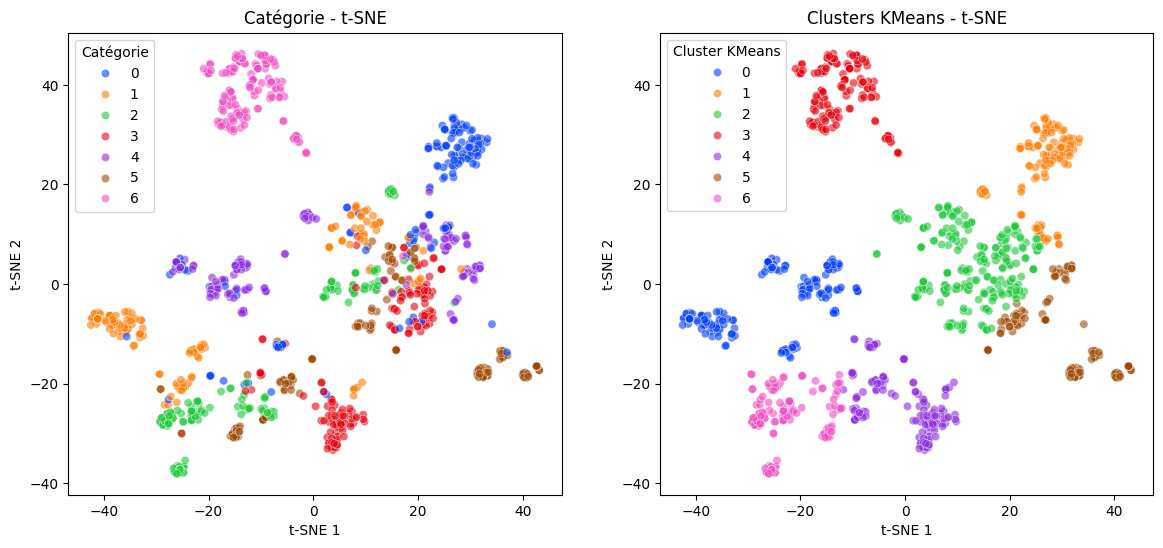

Adjusted Rand Index: 0.339673046412552


In [76]:
compare_real_categories_vs_kmeans_clusters('Word2Vec', df_word2vec, 'Catégorie', 't-SNE', we_duration, w2v_duration)

In [77]:
# Affichage des métriques
display(df_metrics.sort_values('Score ARI', ascending=False))

,Modèle,Méthode de réduction de dimensions,Score ARI,Durée totale,Durée de prétraitement,Durée d'extraction des features
1,Tf-idf,t-SNE,0.539316,6.48 secs,6.43 secs,0.04 secs
0,CountVectorizer,t-SNE,0.404817,6.54 secs,6.43 secs,0.1 secs
2,Word2Vec,t-SNE,0.339673,6.51 secs,6.44 secs,0.07 secs


### 2.3.4 Approche SBERT

* L'algotrithme **SBERT** (**S**entence-**BERT**) est une modification du modèle **BERT** (**B**idirectional **E**ncoder **R**epresentation from **T**ransfomers)  
* SBERT est conçu pour trouver des similitudes entre les phrases, et fonctionne avec une liste de phrases complètes (sans prétraitement particulier)  

#### 2.3.4.1 Sentence embedding

* La feature `product_name` n'étant pas formulée sous forme de phrase, la liste d'entrée sera la liste des features `description` uniquement

In [78]:
start_se = time.perf_counter()

# Récupération de la liste globale des descriptions
sentences = df_datas['description'].to_list()

end_se = time.perf_counter()
se_duration = end_se - start_se

#### 2.3.4.2 Feature extraction

In [79]:
# Gestion du FAST_MODE
data_filename = 'df_sbert.csv'
duration_filename = 'sbert_duration.txt'
if FAST_MODE and os.path.exists(data_filename):
    print(f"FAST_MODE ON : chargement '{data_filename}'")
    df_sbert = pd.read_csv(data_filename)
    if os.path.exists(duration_filename):
        with open(duration_filename, 'r') as file:
            duration_line = file.readline()
            sbert_duration = float(duration_line.split(": ")[1].strip().split(" ")[0])
    else:
        sbert_duration = np.nan
        print(f"Avertissement : fichier '{duration_filename}' absent.")
else:
    start_sbert = time.perf_counter()

    # Initialisation du modèle
    sbert_model = SentenceTransformer('all-mpnet-base-v2')
    
    # Récupérations des vecteurs BERT dans un np.array
    sbert_array = sbert_model.encode(sentences)
    
    end_sbert = time.perf_counter()
    sbert_duration = end_sbert - start_sbert

    # Création d'un DataFrame avec les vecteurs
    df_sbert = pd.DataFrame(
        sbert_array,
        columns=[f'vec_{i}' for i in range(sbert_array.shape[1])]
    )
    # Ajout de la feature 'Catégorie'
    df_sbert['Catégorie'] = df_datas['Catégorie']

    # Sauvegarde données
    df_sbert.to_csv(data_filename, index=False)
    # Sauvegarde durée
    with open(duration_filename, 'w') as file:
        file.write(f"Durée d'extraction des features SBERT : {sbert_duration} secondes")

FAST_MODE ON : chargement 'df_sbert.csv'


* Création d'un DataFrame avec les vecteurs SBERT et une feature `Catégorie` contenant la catégorie réelle des produits

In [80]:
# Affichage de quelques exemples
display(df_sbert.sample(5))

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_759,vec_760,vec_761,vec_762,vec_763,vec_764,vec_765,vec_766,vec_767,Catégorie
781,-0.014271,0.006223,-0.002431,0.006186,0.036330,-0.009227,0.026137,-0.012986,-0.036819,0.092936,...,0.003850,-0.086302,0.000200,-0.013147,0.063640,0.010972,0.035528,-0.038511,-0.016161,6
893,-0.020853,-0.078597,0.002540,-0.003585,-0.036387,-0.061669,0.056606,0.018981,0.017615,0.010222,...,-0.006620,0.047777,0.011630,-0.008269,-0.006618,-0.030987,-0.022143,-0.029714,0.017562,4
330,0.034062,0.024780,0.029606,0.014647,0.020995,-0.022898,-0.002744,0.036593,-0.020563,-0.024374,...,0.033878,-0.018854,0.036456,-0.007090,0.058162,-0.036082,-0.007140,-0.022074,-0.019934,2
885,0.005381,-0.064916,0.003920,-0.011429,-0.006017,-0.057998,0.036190,0.038692,-0.016797,0.034683,...,0.015346,0.035457,0.011875,0.013690,0.012369,-0.022886,-0.026499,0.005742,0.005791,4
934,0.012053,-0.011943,-0.022964,0.026828,-0.000383,0.015053,0.010707,-0.007558,-0.104942,0.001729,...,0.013395,0.022657,-0.011688,-0.000545,0.034286,-0.003337,0.016288,-0.025088,-0.011146,4


#### 2.3.3.3 Réduction de dimension et visualisation

* Réduction en 2 dimensions via t-SNE et représentation des produits

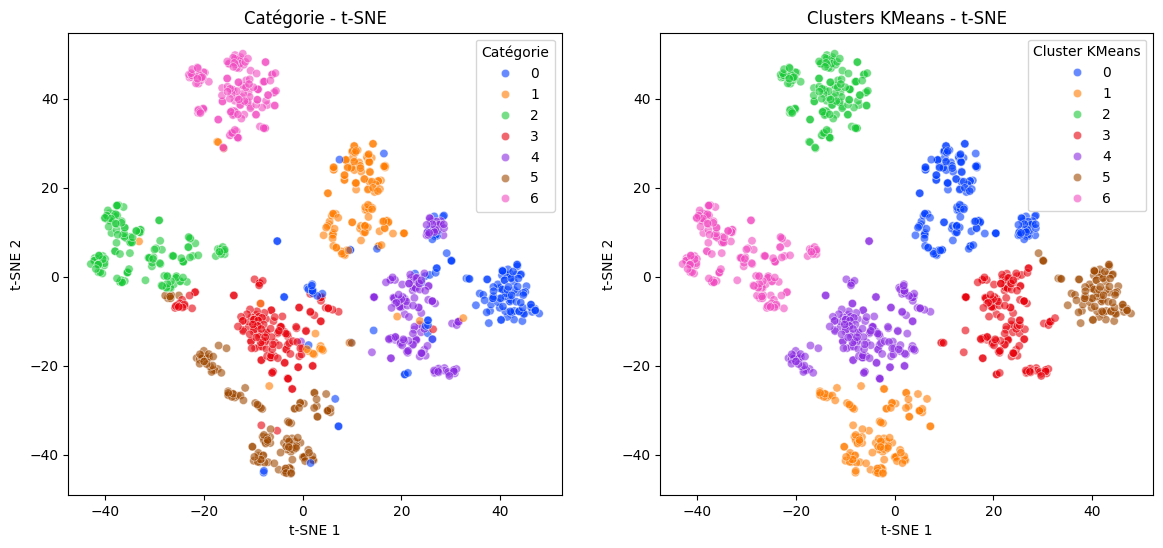

Adjusted Rand Index: 0.7119088658621565


In [81]:
compare_real_categories_vs_kmeans_clusters('SBERT', df_sbert, 'Catégorie', 't-SNE', se_duration, sbert_duration)

In [82]:
# Affichage des métriques
display(df_metrics.sort_values('Score ARI', ascending=False))

,Modèle,Méthode de réduction de dimensions,Score ARI,Durée totale,Durée de prétraitement,Durée d'extraction des features
3,SBERT,t-SNE,0.711909,87.08 secs,0.0 secs,87.08 secs
1,Tf-idf,t-SNE,0.539316,6.48 secs,6.43 secs,0.04 secs
0,CountVectorizer,t-SNE,0.404817,6.54 secs,6.43 secs,0.1 secs
2,Word2Vec,t-SNE,0.339673,6.51 secs,6.44 secs,0.07 secs


### 2.3.5 Approche USE

* L'algorithme **USE** (**U**niversal **S**entence **E**ncoder) est conçu pour encoder des phrases, des paragraphes ou des documents entiers en vecteurs numériques
* Les modèles USE sont entraînés sur un large corpus, ce qui permet d'obtenir des embeddings de grande qualité
* Tout comme SBERT, il fonctionne avec des phrases complètes, sans prétraitement particulier

#### 2.3.5.1 Prétraitement

* Il s'agit juste de fournir à l'algorithme une liste de documents sous forme de phrases
* La liste `sentences` a déjà été préparée pour SBERT

#### 2.3.5.2 feature extraction

In [84]:
# Gestion du FAST_MODE
data_filename = 'df_use.csv'
duration_filename = 'use_duration.txt'
if FAST_MODE and os.path.exists(data_filename):
    print(f"FAST_MODE ON : chargement '{data_filename}'")
    df_use = pd.read_csv(data_filename)
    if os.path.exists(duration_filename):
        with open(duration_filename, 'r') as file:
            duration_line = file.readline()
            use_duration = float(duration_line.split(": ")[1].strip().split(" ")[0])
    else:
        use_duration = np.nan
        print(f"Avertissement : fichier '{duration_filename}' absent.")
else:
    start_use = time.perf_counter()

    # Chargement du modèle USE depuis TensorFlow Hub
    use_model = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
    
    # Récupérations des vecteurs USE dans un np.array
    use_array = use_model(sentences)
    
    end_use = time.perf_counter()
    use_duration = end_use - start_use

    # Création d'un DataFrame avec les vecteurs
    df_use = pd.DataFrame(
        use_array,
        columns=[f'vec_{i}' for i in range(use_array.shape[1])]
    )
    # Ajout de la feature 'Catégorie'
    df_use['Catégorie'] = df_datas['Catégorie']

    # Sauvegarde données
    df_use.to_csv(data_filename, index=False)
    # Sauvegarde durée
    with open(duration_filename, 'w') as file:
        file.write(f"Durée d'extraction des features USE : {use_duration} secondes")

FAST_MODE ON : chargement 'df_use.csv'


In [85]:
# Affichage de quelques exemples
display(df_use.sample(5))

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_503,vec_504,vec_505,vec_506,vec_507,vec_508,vec_509,vec_510,vec_511,Catégorie
73,-0.067076,-0.045068,-0.054886,-0.029054,-0.056927,0.037768,0.017001,-0.031161,0.004280,-0.010274,...,-0.056735,0.026147,0.042798,-0.046725,-0.057090,0.054239,0.054616,0.043282,0.019330,0
200,-0.075338,-0.082379,0.029485,0.037897,0.064118,0.044413,-0.027650,0.016108,-0.016752,-0.075360,...,-0.002705,-0.029903,-0.005551,-0.019679,0.014386,0.008121,-0.061852,0.053561,-0.036231,3
292,-0.059745,-0.040849,-0.040653,0.029751,0.049129,0.009805,0.003090,0.048560,0.059453,-0.051049,...,-0.060493,-0.004220,0.055696,-0.059630,-0.036861,0.042262,0.042306,-0.054071,-0.033154,0
917,-0.061620,0.025790,0.036248,-0.014112,-0.057854,-0.020623,-0.037267,-0.060051,0.027917,-0.023880,...,-0.067716,-0.052341,0.050228,-0.048474,0.037717,0.030726,0.062903,-0.063148,-0.048070,3
248,-0.064142,-0.073059,-0.001715,-0.021660,0.046732,0.049211,-0.046920,0.000862,-0.003439,-0.070517,...,-0.051984,0.016804,0.044227,-0.017543,0.056916,0.073245,-0.030553,0.027464,-0.073430,3


#### 2.3.5.3 Réduction de dimension et visualisation

* Réduction en 2 dimensions via t-SNE et représentation des produits

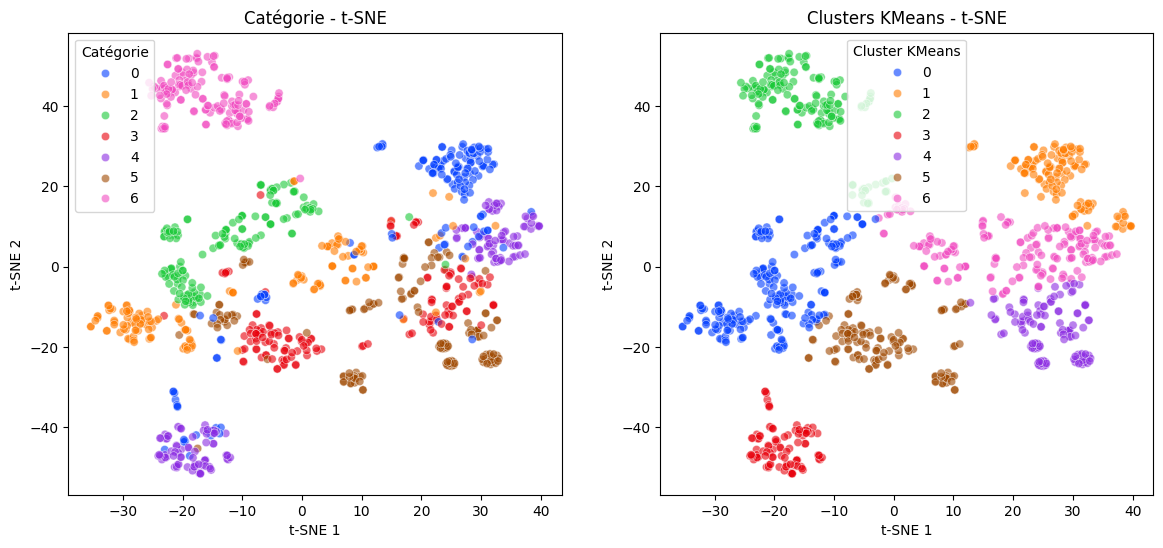

Adjusted Rand Index: 0.37796046732314115


In [86]:
compare_real_categories_vs_kmeans_clusters('USE', df_use, 'Catégorie', 't-SNE', se_duration, use_duration)

In [87]:
# Affichage des métriques
display(df_metrics.sort_values('Score ARI', ascending=False))

,Modèle,Méthode de réduction de dimensions,Score ARI,Durée totale,Durée de prétraitement,Durée d'extraction des features
3,SBERT,t-SNE,0.711909,87.08 secs,0.0 secs,87.08 secs
1,Tf-idf,t-SNE,0.539316,6.48 secs,6.43 secs,0.04 secs
0,CountVectorizer,t-SNE,0.404817,6.54 secs,6.43 secs,0.1 secs
4,USE,t-SNE,0.377960,4.97 secs,0.0 secs,4.97 secs
2,Word2Vec,t-SNE,0.339673,6.51 secs,6.44 secs,0.07 secs
